<hr/>

# imports

In [12]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn
import imblearn

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [15]:

def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [16]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [17]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse

    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    data['sender_labels_encoded'] = data['sender_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data['receiver_labels_encoded'] = data['receiver_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data["game_score_delta"] = data['game_score_delta'].astype(float)
    return data

In [18]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, skip_evaluation: bool = False) -> tuple[float, float]:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        skip_evaluation: bool
            skip the model.evaluate() function
    """
    def find_best_threshold(y_true, y_probs):
        best_threshold = 0.5
        best_f1 = 0.0

        # Iterate over a range of thresholds (e.g., 0.0 to 1.0)
        for threshold in np.arange(0.0, 1.0, 0.01):
            # Convert probabilities to binary predictions based on the current threshold
            y_pred = (y_probs > threshold).astype(int)

            # Calculate the F1 score
            f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')

            # If this F1 score is better than the best so far, update the best threshold and F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        return best_threshold, best_f1

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['sender_output_auc'], label='sender_output_auc', color="tan", linestyle="dashed")
    plt.plot(history.history['val_sender_output_auc'], label = 'val_sender_output_auc', color="darkorange")
    plt.plot(history.history['receiver_output_auc_1'], label='receiver_output_auc', color="cornflowerblue" , linestyle="dashed")
    plt.plot(history.history['val_receiver_output_auc_1'], label = 'val_receiver_output_auc', color="darkblue")
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.ylim([0.0, 1.03])
    plt.legend(loc='lower right')
    plt.show()

    if not skip_evaluation:
        print(f"{'='*10} Test Evaluation {'='*10}")
        model.evaluate(test_ds, test_target, verbose=2)
        # print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
        print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)

    # Find the best threshold for sender
    best_threshold_sender, best_f1_sender = find_best_threshold(test_target[0], y_pred[0])
    #print("Best Threshold for Sender:", best_threshold_sender, "with F1 Score:", best_f1_sender)

    # Find the best threshold for receiver
    best_threshold_receiver, best_f1_receiver = find_best_threshold(test_target[1], y_pred[1])
    #print("Best Threshold for Receiver:", best_threshold_receiver, "with F1 Score:", best_f1_receiver)

      # Convert probabilities to binary predictions
    y_pred_sender = (y_pred[0] > best_threshold_sender).astype(int).reshape(-1)
    y_pred_receiver = (y_pred[1] > best_threshold_receiver).astype(int).reshape(-1)

    print()
    print(f"{'-'*10} Sender Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[0], y_pred_sender, target_names=["True", "False"], zero_division=0, digits=3))
    print(f"{'-'*10} Receiver Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[1], y_pred_receiver, target_names=["True", "False"], zero_division=0, digits=3))

    return best_threshold_sender, best_threshold_receiver

In [19]:

def Tokenize(tokenizer, df: pd.DataFrame, sequence_len: int = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

In [20]:
def PredictionGridPeek(pred: list, df: pd.DataFrame, target_labels: list, who: str) -> pd.DataFrame:
    table = {
        "prediction": [],
        "target": [],
        "message": [],
        "context": []
    }
    for match in [True, False]:
        bool_stmt = pred == df[f'{who}_labels_encoded'] if match else pred != df[f'{who}_labels_encoded']
        visited = []
        for i in range(0, len(pred[bool_stmt])):
            row = df[bool_stmt].iloc[i,:]
            pred_label = target_labels[pred[bool_stmt][i]]
            if (pred_label, row[f'{who}_labels']) not in visited:
                table["prediction"].append(pred_label)
                table["target"].append(row[f'{who}_labels'])
                table['message'].append(row['messages'])
                table['context'].append(row['previous_message'])
                visited.append((pred_label, row[f'{who}_labels']))
                if len(visited) >= len(target_labels):
                    break
    return pd.DataFrame(table)

<hr/>

# data explortion

just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

## NOANNOTATION

In [21]:
# train_df = (parse_jsonl("./data/train.jsonl"))
# test_df = (parse_jsonl("./data/test.jsonl"))
# validation_df = (parse_jsonl("./data/validation.jsonl"))

# from google.colab import drive
# drive.mount('/content/drive')

# folder_path = '/content/drive/My Drive/Colab Notebooks/w266 Final Project'
folder_path = '/home/jovyan/work/mnt/266/project/w266-final-project'

train_df = (parse_jsonl(f"{folder_path}/data/train.jsonl"))
test_df = (parse_jsonl(f"{folder_path}/data/test.jsonl"))
validation_df = (parse_jsonl(f"{folder_path}/data/validation.jsonl"))

In [22]:

train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0.0,1,0,It seems like there are a lot of ways that cou...,straightforward,0,2


# NOANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value

In [23]:
print("NOANNOTATION percentage in:")
print(f'train = {(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index)) * 100:.2f}%')
print(f'test = {(len(test_df[test_df["receiver_labels"] == "NOANNOTATION"].index) /  len(test_df.index)) * 100:.2f}%')
print(f'validation = {(len(validation_df[validation_df["receiver_labels"] == "NOANNOTATION"].index) /  len(validation_df.index)) * 100:.2f}%')

NOANNOTATION percentage in:
train = 8.43%
test = 9.70%
validation = 9.39%


The percentages are low in each dataset and "NOANNOTATION" does not provide any meaningful value so we will remove it to keep the results a boolean value `True` or `False`.

In [24]:
train_df = train_df[train_df["receiver_labels"] != "NOANNOTATION"]
test_df = test_df[test_df['receiver_labels'] != "NOANNOTATION"]
validation_df = validation_df[validation_df['receiver_labels'] != "NOANNOTATION"]

# Unique Words

In [25]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 11
just: 1146
the: 6037
person: 28
i: 8250
want: 779
to: 10653
speak: 17
with.: 34
have: 1944
a: 4399
somewhat: 15
crazy: 15
idea: 89
that: 3414
i’ve: 139
always: 75
wanted: 136
try: 284
with: 2364
i/g,: 1
but: 2086
never: 96
actually: 195
convinced: 11
other: 271
guy: 29
it.: 244
and,: 34
what’s: 73
worse,: 3


In [26]:
len(unique_words)

14991

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

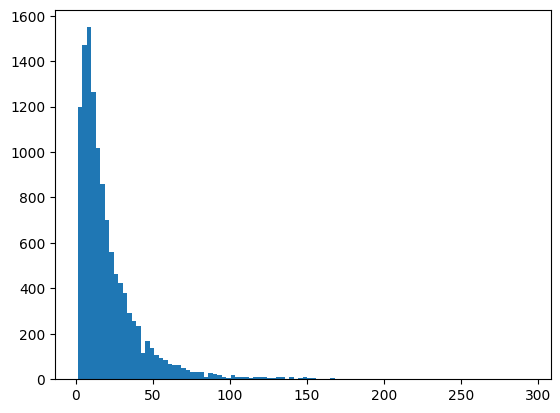

In [27]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [28]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,12025
1,Average words per message,20
2,Unique word count,14991
3,Actual Lie count,545
4,Actual Truth count,11480


# Label count

In [29]:
train_df['label'].value_counts()

label
straightforward    10979
cassandra            501
deceive              480
caught                65
Name: count, dtype: int64

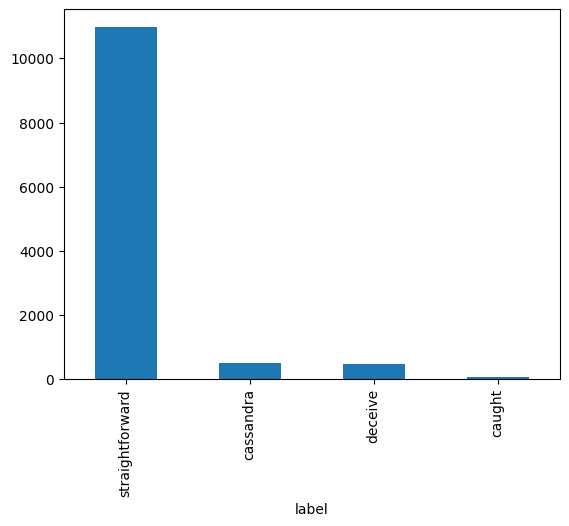

In [30]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [31]:
train_df['label'].value_counts(normalize=True)

label
straightforward    0.913015
cassandra          0.041663
deceive            0.039917
caught             0.005405
Name: proportion, dtype: float64

<hr/>

# Constants

In [32]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)
EMBEDDING_OUTPUT_SIZE = 124
LSTM_SIZE = 1024
DROPOUT_RATE = 0.15
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 2e-5

CLASS_LABELS = ["True", "False"]

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
# smote = imblearn.over_sampling.SMOTE()

# train_encoded_padded, y_train = smote.fit_resample(train_tokenized_padded, train_df['label_encoded'])
# train_prev_encoded_padded, y_train = smote.fit_resample(train_prev_tokenized_padded, train_df['label_encoded'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

# Naive Bayes Baseline

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# CountVectorizer and TfidfTransformer
count_vect = CountVectorizer(max_features=VOCAB_SIZE)
tf_transformer = TfidfTransformer(use_idf=False)

# Process for sender labels
X_train_sender = count_vect.fit_transform(train_df['messages'])
X_train_sender_tf = tf_transformer.fit_transform(X_train_sender)
y_train_sender = train_df['sender_labels_encoded']

# Process for receiver labels
X_train_receiver = count_vect.fit_transform(train_df['messages'])
X_train_receiver_tf = tf_transformer.fit_transform(X_train_receiver)
y_train_receiver = train_df['receiver_labels_encoded']


# Initialize SMOTE
oversample = SMOTE()

# Apply SMOTE for sender labels
X_train_sender_smote, y_train_sender_smote = oversample.fit_resample(X_train_sender_tf, y_train_sender)
clf_sender = MultinomialNB().fit(X_train_sender_smote, y_train_sender_smote)

# Apply SMOTE for receiver labels
X_train_receiver_smote, y_train_receiver_smote = oversample.fit_resample(X_train_receiver_tf, y_train_receiver)
clf_receiver = MultinomialNB().fit(X_train_receiver_smote, y_train_receiver_smote)

X_test = count_vect.transform(test_df['messages'])
X_test_tf = tf_transformer.transform(X_test)
y_test_sender = test_df['sender_labels_encoded']
y_test_receiver = test_df['receiver_labels_encoded']


# Evaluation for sender labels
y_test_pred_sender = clf_sender.predict(X_test_tf)
print("Test Metrics for Sender Labels")
print(metrics.classification_report(y_test_sender, y_test_pred_sender, digits=3))

# Evaluation for receiver labels
y_test_pred_receiver = clf_receiver.predict(X_test_tf)
print("Test Metrics for Receiver Labels")
print(metrics.classification_report(y_test_receiver, y_test_pred_receiver, digits=3))

Test Metrics for Sender Labels
              precision    recall  f1-score   support

           0      0.927     0.704     0.800      2268
           1      0.108     0.391     0.169       207

    accuracy                          0.678      2475
   macro avg      0.517     0.548     0.484      2475
weighted avg      0.858     0.678     0.747      2475

Test Metrics for Receiver Labels
              precision    recall  f1-score   support

           0      0.943     0.734     0.826      2310
           1      0.092     0.376     0.147       165

    accuracy                          0.710      2475
   macro avg      0.517     0.555     0.486      2475
weighted avg      0.886     0.710     0.780      2475



<hr/>

# Naive Neural Network

In [98]:
def create_naive_model(
        vocab_size: int = VOCAB_SIZE,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        sequence_length: int = MAX_SEQUENCE_LEN,
        hidden_size: int = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_size, activation="relu")
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(naive_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(naive_output)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

In [99]:
naive_model = create_naive_model()
naive_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 flatten_4 (Flatten)         (None, 36456)                0         ['embedding_10[0][0]']        
                                                                                                  
 dense_9 (Dense)             (None, 128)                  4666496   ['flatten_4[0][0]']           
                                                                                            

In [100]:
naive_history = naive_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 19s 46ms/step - loss: 0.4054 - sender_output_loss: 0.1984 - receiver_output_loss: 0.2070 - sender_output_auc: 0.5796 - receiver_output_auc_1: 0.5154 - val_loss: 0.3193 - val_sender_output_loss: 0.1604 - val_receiver_output_loss: 0.1588 - val_sender_output_auc: 0.6247 - val_receiver_output_auc_1: 0.4851
Epoch 2/10
376/376 [==============================] - 4s 11ms/step - loss: 0.3710 - sender_output_loss: 0.1815 - receiver_output_loss: 0.1895 - sender_output_auc: 0.5932 - receiver_output_auc_1: 0.5346 - val_loss: 0.3177 - val_sender_output_loss: 0.1599 - val_receiver_output_loss: 0.1579 - val_sender_output_auc: 0.6374 - val_receiver_output_auc_1: 0.4611
Epoch 3/10
376/376 [==============================] - 4s 10ms/step - loss: 0.3693 - sender_output_loss: 0.1804 - receiver_output_loss: 0.1889 - sender_output_auc: 0.6081 - receiver_output_auc_1: 0.5511 - val_loss: 0.3182 - val_sender_output_loss: 0.1596 - val_receiver_output_loss: 0.1

========== Model Accuracy ==========


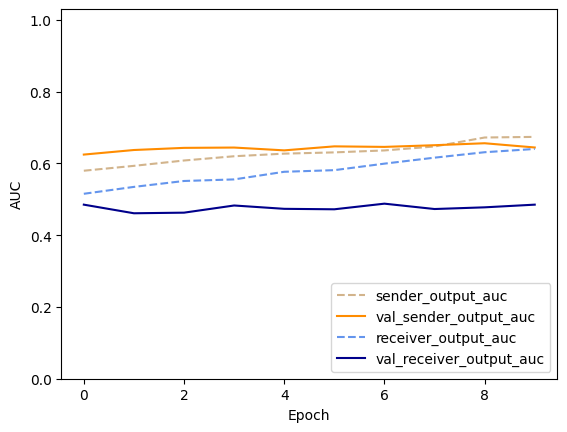

========== Test Evaluation ==========
78/78 - 0s - loss: 0.5404 - sender_output_loss: 0.2916 - receiver_output_loss: 0.2487 - sender_output_auc: 0.6615 - receiver_output_auc_1: 0.6149 - 214ms/epoch - 3ms/step

========== Test Metrics ==========
78/78 [==============================] - 0s 2ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.927     0.924     0.926      2268
       False      0.199     0.208     0.203       207

    accuracy                          0.864      2475
   macro avg      0.563     0.566     0.564      2475
weighted avg      0.866     0.864     0.865      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.939     0.879     0.908      2310
       False      0.103     0.194     0.134       165

    accuracy                          0.833      2475
   macro avg      0.521     0.536     0.521      2475
weighted avg      0.883     

In [101]:
EvaluateModel(naive_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_history);

# Naive LSTM

In [34]:
def create_naive_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_lstm_ouput = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(naive_lstm_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(naive_lstm_ouput)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

In [35]:
naive_lstm_model = create_naive_lstm_model()
naive_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 lstm (LSTM)                 (None, 1024)                 4706304   ['embedding[0][0]']           
                                                                                                  
 dense (Dense)               (None, 128)                  131200    ['lstm[0][0]']                
                                                                                              

In [36]:
naive_lstm_history = naive_lstm_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 42s 101ms/step - loss: 0.4714 - sender_output_loss: 0.2337 - receiver_output_loss: 0.2376 - sender_output_auc: 0.5454 - receiver_output_auc_1: 0.5268 - val_loss: 0.3212 - val_sender_output_loss: 0.1616 - val_receiver_output_loss: 0.1597 - val_sender_output_auc: 0.6409 - val_receiver_output_auc_1: 0.4755
Epoch 2/10
376/376 [==============================] - 26s 69ms/step - loss: 0.3739 - sender_output_loss: 0.1829 - receiver_output_loss: 0.1910 - sender_output_auc: 0.5747 - receiver_output_auc_1: 0.5388 - val_loss: 0.3199 - val_sender_output_loss: 0.1611 - val_receiver_output_loss: 0.1588 - val_sender_output_auc: 0.6447 - val_receiver_output_auc_1: 0.4762
Epoch 3/10
376/376 [==============================] - 25s 66ms/step - loss: 0.3746 - sender_output_loss: 0.1829 - receiver_output_loss: 0.1917 - sender_output_auc: 0.5789 - receiver_output_auc_1: 0.5209 - val_loss: 0.3372 - val_sender_output_loss: 0.1635 - val_receiver_output_loss: 

========== Model Accuracy ==========


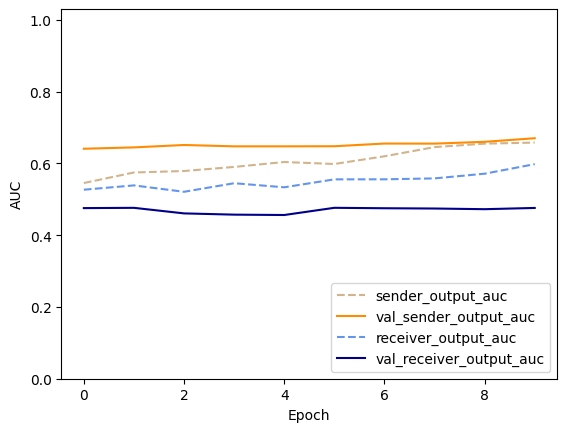

========== Test Evaluation ==========
78/78 - 2s - loss: 0.5316 - sender_output_loss: 0.2850 - receiver_output_loss: 0.2465 - sender_output_auc: 0.6711 - receiver_output_auc_1: 0.6352 - 2s/epoch - 24ms/step

========== Test Metrics ==========
78/78 [==============================] - 2s 22ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.929     0.933     0.931      2268
       False      0.231     0.222     0.227       207

    accuracy                          0.873      2475
   macro avg      0.580     0.577     0.579      2475
weighted avg      0.871     0.873     0.872      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.943     0.923     0.933      2310
       False      0.165     0.212     0.186       165

    accuracy                          0.876      2475
   macro avg      0.554     0.568     0.559      2475
weighted avg      0.891     0

In [37]:
EvaluateModel(naive_lstm_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_lstm_history);

<hr/>

# Context lstm

In [38]:
def create_context_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(512),
        keras.layers.Dropout(dropout)
    )

    context_lstm_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_lstm_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_lstm_ouput)

    context_lstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_lstm_model

In [39]:
context_lstm_model = create_context_lstm_model()
context_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_1 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

In [40]:
context_lstm_history = context_lstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 49s 117ms/step - loss: 0.4708 - sender_output_loss: 0.2278 - receiver_output_loss: 0.2430 - sender_output_auc: 0.5776 - receiver_output_auc_1: 0.5055 - val_loss: 0.3388 - val_sender_output_loss: 0.1717 - val_receiver_output_loss: 0.1671 - val_sender_output_auc: 0.6330 - val_receiver_output_auc_1: 0.4577
Epoch 2/10
376/376 [==============================] - 35s 93ms/step - loss: 0.3744 - sender_output_loss: 0.1828 - receiver_output_loss: 0.1916 - sender_output_auc: 0.5772 - receiver_output_auc_1: 0.5283 - val_loss: 0.3208 - val_sender_output_loss: 0.1623 - val_receiver_output_loss: 0.1584 - val_sender_output_auc: 0.6279 - val_receiver_output_auc_1: 0.4613
Epoch 3/10
376/376 [==============================] - 33s 88ms/step - loss: 0.3741 - sender_output_loss: 0.1835 - receiver_output_loss: 0.1906 - sender_output_auc: 0.5652 - receiver_output_auc_1: 0.5372 - val_loss: 0.3309 - val_sender_output_loss: 0.1677 - val_receiver_output_loss: 

========== Model Accuracy ==========


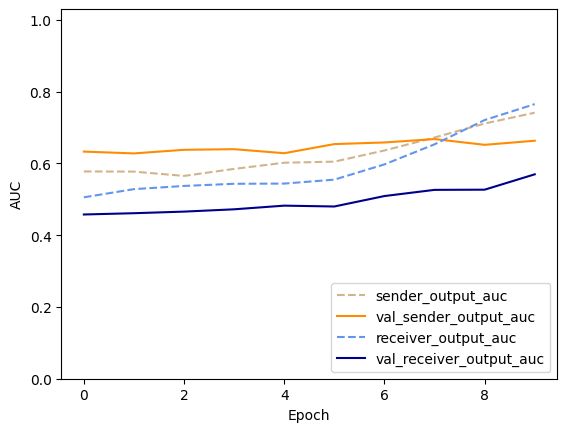

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5359 - sender_output_loss: 0.2870 - receiver_output_loss: 0.2489 - sender_output_auc: 0.6208 - receiver_output_auc_1: 0.5983 - 3s/epoch - 34ms/step

========== Test Metrics ==========
78/78 [==============================] - 3s 32ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.927     0.934     0.930      2268
       False      0.207     0.188     0.197       207

    accuracy                          0.872      2475
   macro avg      0.567     0.561     0.564      2475
weighted avg      0.866     0.872     0.869      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.942     0.914     0.928      2310
       False      0.146     0.206     0.171       165

    accuracy                          0.867      2475
   macro avg      0.544     0.560     0.549      2475
weighted avg      0.889     0

In [41]:
sender_threshold, receiver_threshold = EvaluateModel(context_lstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_history)

# LSTM + Power

In [110]:
def create_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    lstm_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    lstm_power_ouput = pipe(
        [
            lstm_output,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(lstm_power_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(lstm_power_ouput)

    lstm_power_model = keras.Model(
        inputs=[message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    lstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return lstm_power_model

In [111]:
lstm_power_model = create_lstm_power_model()
lstm_power_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 embedding_14 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                             
                                                                                                  
 lstm_9 (LSTM)               (None, 1024)                 4706304   ['embedding_14[0][0]']        
                                                                                           

In [112]:
lstm_power_history = context_lstm_model.fit(
    [train_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 24s 58ms/step - loss: 0.3630 - sender_output_loss: 0.1760 - receiver_output_loss: 0.1870 - sender_output_auc: 0.6592 - receiver_output_auc_1: 0.6018 - val_loss: 0.3197 - val_sender_output_loss: 0.1589 - val_receiver_output_loss: 0.1608 - val_sender_output_auc: 0.6664 - val_receiver_output_auc_1: 0.4794
Epoch 2/10
376/376 [==============================] - 20s 54ms/step - loss: 0.3566 - sender_output_loss: 0.1709 - receiver_output_loss: 0.1857 - sender_output_auc: 0.6997 - receiver_output_auc_1: 0.6123 - val_loss: 0.3232 - val_sender_output_loss: 0.1615 - val_receiver_output_loss: 0.1617 - val_sender_output_auc: 0.6682 - val_receiver_output_auc_1: 0.4896
Epoch 3/10
376/376 [==============================] - 20s 53ms/step - loss: 0.3534 - sender_output_loss: 0.1697 - receiver_output_loss: 0.1837 - sender_output_auc: 0.7063 - receiver_output_auc_1: 0.6374 - val_loss: 0.3199 - val_sender_output_loss: 0.1591 - val_receiver_output_loss: 0

========== Model Accuracy ==========


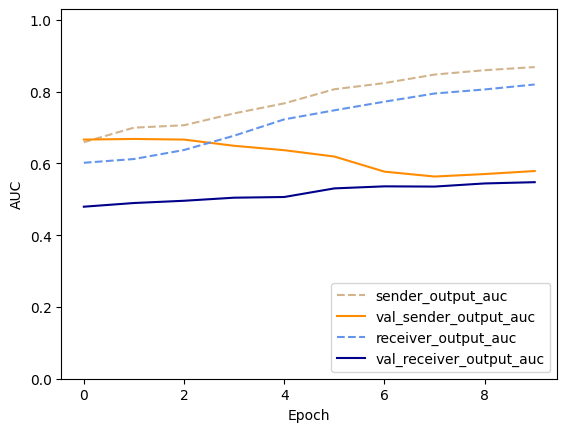

========== Test Evaluation ==========
78/78 - 3s - loss: 1.4022 - sender_output_loss: 0.7058 - receiver_output_loss: 0.6964 - sender_output_auc: 0.5670 - receiver_output_auc_1: 0.5613 - 3s/epoch - 33ms/step

========== Test Metrics ==========
78/78 [==============================] - 2s 18ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.922     0.864     0.892      2268
       False      0.120     0.203     0.151       207

    accuracy                          0.809      2475
   macro avg      0.521     0.534     0.522      2475
weighted avg      0.855     0.809     0.830      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.935     0.978     0.956      2310
       False      0.138     0.048     0.072       165

    accuracy                          0.916      2475
   macro avg      0.536     0.513     0.514      2475
weighted avg      0.882     0

In [113]:
EvaluateModel(lstm_power_model, [test_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], lstm_power_history);

# Context LSTM + Power

In [42]:
def create_context_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_power_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_lstm_power_ouput)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_lstm_power_ouput)

    context_lstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_lstm_power_model

In [43]:
context_lstm_power_model = create_context_lstm_power_model()
context_lstm_power_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_3 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

In [44]:
context_lstm_power_history = context_lstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 57s 138ms/step - loss: 0.4757 - sender_output_loss: 0.2309 - receiver_output_loss: 0.2448 - sender_output_auc: 0.5741 - receiver_output_auc_1: 0.4958 - val_loss: 0.3332 - val_sender_output_loss: 0.1644 - val_receiver_output_loss: 0.1689 - val_sender_output_auc: 0.6194 - val_receiver_output_auc_1: 0.3970
Epoch 2/10
376/376 [==============================] - 44s 118ms/step - loss: 0.3719 - sender_output_loss: 0.1800 - receiver_output_loss: 0.1920 - sender_output_auc: 0.6151 - receiver_output_auc_1: 0.5177 - val_loss: 0.3336 - val_sender_output_loss: 0.1689 - val_receiver_output_loss: 0.1647 - val_sender_output_auc: 0.6287 - val_receiver_output_auc_1: 0.4263
Epoch 3/10
376/376 [==============================] - 43s 115ms/step - loss: 0.3699 - sender_output_loss: 0.1794 - receiver_output_loss: 0.1905 - sender_output_auc: 0.6226 - receiver_output_auc_1: 0.5371 - val_loss: 0.3225 - val_sender_output_loss: 0.1630 - val_receiver_output_loss

========== Model Accuracy ==========


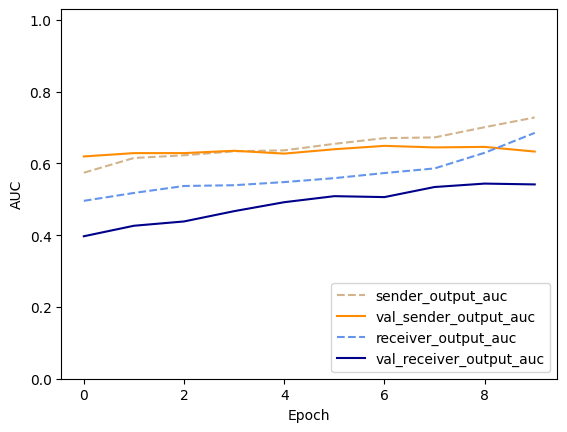

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5388 - sender_output_loss: 0.2962 - receiver_output_loss: 0.2427 - sender_output_auc: 0.6621 - receiver_output_auc_1: 0.6307 - 3s/epoch - 43ms/step

========== Test Metrics ==========
78/78 [==============================] - 4s 41ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.933     0.896     0.914      2268
       False      0.203     0.290     0.239       207

    accuracy                          0.846      2475
   macro avg      0.568     0.593     0.577      2475
weighted avg      0.872     0.846     0.858      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.944     0.897     0.920      2310
       False      0.147     0.248     0.185       165

    accuracy                          0.854      2475
   macro avg      0.545     0.573     0.552      2475
weighted avg      0.890     0

In [45]:
EvaluateModel(context_lstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_power_history);

<hr/>

# Context LSTM Prediction Analysis

In [118]:
pred = context_lstm_model.predict([test_encoded_padded, test_prev_encoded_padded])
sender_pred = (pred[0] > sender_threshold).astype(int).reshape(-1)
receiver_pred = (pred[1] > receiver_threshold).astype(int).reshape(-1)

display(sender_pred)
display(receiver_pred)

78/78 [==============================] - 3s 34ms/step


array([0, 0, 0, ..., 0, 0, 0])

array([0, 0, 0, ..., 0, 0, 0])

## Sender Predictions

In [119]:
sender_table = PredictionGridPeek(sender_pred, test_df, CLASS_LABELS, "sender")
sender_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,Hello! I'm looking forward to a fun game as we...,Hey Germany! How’s it going? Looking forward t...
2,True,False,"I'd personally rather you didn't, because a pl...","Bongiorno! To crush my enemies, see them driv..."
3,False,True,So I tried to move towards a more forward posi...,"Also, weirdly, my phone doesn't seem to be upd..."


In [120]:
sender_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

"Hello! I'm looking forward to a fun game as well. I usually see good things happen when Russia and Germany work together, so I hope we can both help each other in our initial plans. I'm assuming you're gonna try and attack Scandinavia first? Let me know your thoughts, and I look forward to us working well together"

"I'd personally rather you didn't, because a play around Munich is also a play around Trieste and Vienna. I've heard that there's some rancor over in the West and you might be able to profit from a mobbed France if you went that way."

'So I tried to move towards a more forward position so I could fight France an d stab Russia, and *not* fight you, but you’re kinda putting yourself directly in my way, y’know?'

In [121]:
sender_table["context"].map(display);

''

'Hey Germany! How’s it going? Looking forward to a fun game!'

'Bongiorno!  To crush my enemies, see them driven before me, and hear the lamentations of their women!  I mean, umm, not really sure yet.  Pondering whether or not to make an early play around Munich'

"Also, weirdly, my phone doesn't seem to be updating me with latest messages the way it should, so I end up seeing these a lot later than I should"

## Receiver Predictions

In [122]:
receiver_table = PredictionGridPeek(receiver_pred, test_df, CLASS_LABELS, "receiver")
receiver_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,"As we move forward, once I start taking center...",Perfect. We can’t let him get out of the Medit...
2,True,False,"Well, if you want to attack France in the Medi...","Well....that's a great question, and a lot of ..."
3,False,True,So I tried to move towards a more forward posi...,"Also, weirdly, my phone doesn't seem to be upd..."


In [123]:
receiver_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

'As we move forward, once I start taking centers in the balkans I would be happy to return hol and other centers to keep you strong'

'Well, if you want to attack France in the Mediterranean while I attack through Burgundy you can have Marseille and Iberia while I take Brest and Paris, then with France out of the way you could focus on Turkey or Austria. Sound fair?'

'So I tried to move towards a more forward position so I could fight France an d stab Russia, and *not* fight you, but you’re kinda putting yourself directly in my way, y’know?'

In [124]:
receiver_table["context"].map(display);

''

'Perfect. We can’t let him get out of the Mediterranean'

"Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?"

"Also, weirdly, my phone doesn't seem to be updating me with latest messages the way it should, so I end up seeing these a lot later than I should"

# Context GRU



In [125]:
def create_context_gru_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        gru_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and GRU layers
    current_message_gru = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.GRU(gru_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_gru = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.GRU(gru_size),
        keras.layers.Dropout(dropout)
    )

    # Concatenate GRU outputs
    context_gru_output = pipe(
        [
            current_message_gru,
            previous_message_gru
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_gru_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_gru_output)

    # Model
    context_gru_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_gru_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_gru_model


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_17 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

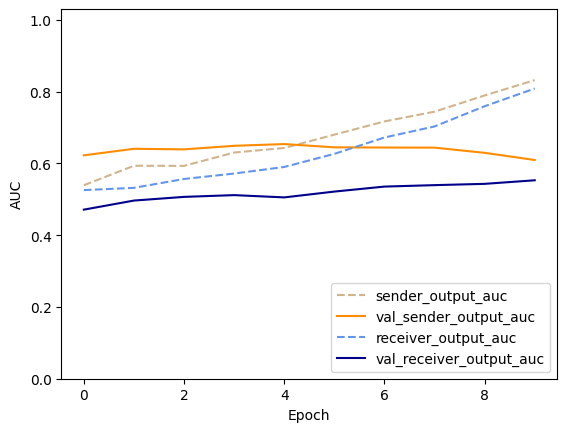

========== Test Evaluation ==========
78/78 - 2s - loss: 0.5530 - sender_output_loss: 0.3014 - receiver_output_loss: 0.2517 - sender_output_auc: 0.6219 - receiver_output_auc_1: 0.5867 - 2s/epoch - 31ms/step

========== Test Metrics ==========
78/78 [==============================] - 3s 28ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.926     0.948     0.937      2268
       False      0.227     0.169     0.194       207

    accuracy                          0.882      2475
   macro avg      0.577     0.558     0.565      2475
weighted avg      0.867     0.882     0.874      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.940     0.915     0.928      2310
       False      0.137     0.188     0.158       165

    accuracy                          0.867      2475
   macro avg      0.538     0.552     0.543      2475
weighted avg      0.887     0

In [126]:
context_gru_model = create_context_gru_model()
context_gru_model.summary()

context_gru_history = context_gru_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_gru_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_gru_history)


# Bi-Directional Context LSTM

In [46]:
def create_context_bilstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.2,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and Bi-LSTM layers
    current_message_bilstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bilstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-LSTM outputs
    context_bilstm_output = pipe(
        [
            current_message_bilstm,
            previous_message_bilstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    # Model
    context_bilstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_5 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

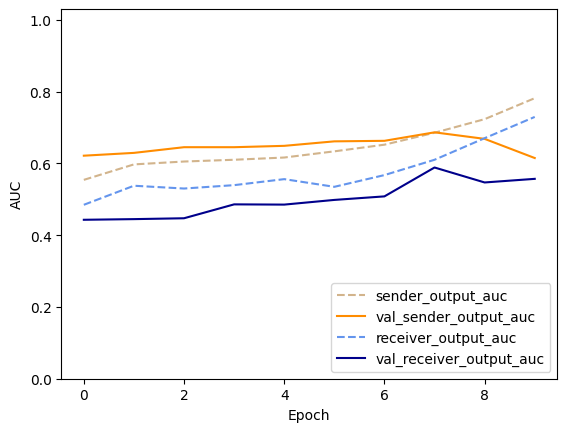

========== Test Evaluation ==========
78/78 - 6s - loss: 0.5330 - sender_output_loss: 0.2894 - receiver_output_loss: 0.2436 - sender_output_auc: 0.5994 - receiver_output_auc_1: 0.5742 - 6s/epoch - 81ms/step

========== Test Metrics ==========
78/78 [==============================] - 7s 78ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.927     0.910     0.918      2268
       False      0.180     0.217     0.197       207

    accuracy                          0.852      2475
   macro avg      0.554     0.564     0.558      2475
weighted avg      0.865     0.852     0.858      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.939     0.943     0.941      2310
       False      0.155     0.145     0.150       165

    accuracy                          0.890      2475
   macro avg      0.547     0.544     0.546      2475
weighted avg      0.887     0

In [47]:
context_bilstm_model = create_context_bilstm_model()
context_bilstm_model.summary()

context_bilstm_history = context_bilstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_history)


# Bi-Directional Context GRU

In [129]:
def create_context_bigru_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        gru_size: int = 1024,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and Bi-GRU layers
    current_message_bigru = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.GRU(gru_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bigru = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.GRU(gru_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-GRU outputs
    context_bigru_output = pipe(
        [
            current_message_bigru,
            previous_message_bigru
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bigru_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bigru_output)

    # Model
    context_bigru_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bigru_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bigru_model


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_21 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

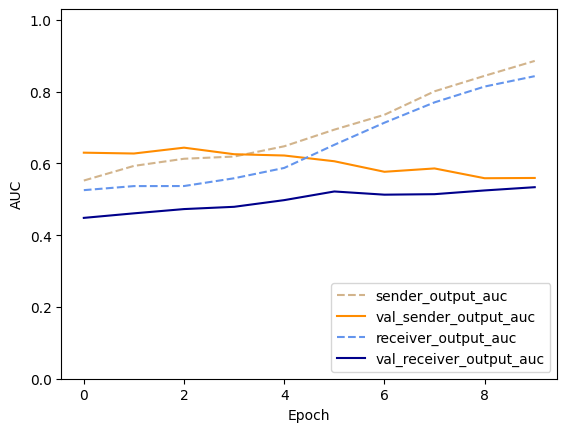

========== Test Evaluation ==========
78/78 - 5s - loss: 0.6892 - sender_output_loss: 0.3908 - receiver_output_loss: 0.2984 - sender_output_auc: 0.5677 - receiver_output_auc_1: 0.5585 - 5s/epoch - 59ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 57ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.924     0.958     0.941      2268
       False      0.228     0.135     0.170       207

    accuracy                          0.889      2475
   macro avg      0.576     0.547     0.555      2475
weighted avg      0.866     0.889     0.876      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.938     0.945     0.942      2310
       False      0.143     0.127     0.135       165

    accuracy                          0.891      2475
   macro avg      0.541     0.536     0.538      2475
weighted avg      0.885     0

In [130]:
context_bigru_model = create_context_bigru_model()
context_bigru_model.summary()

context_bigru_history = context_bigru_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bigru_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bigru_history)


# Bi-Directional LSTM with CNN

In [131]:
def create_context_bilstm_cnn_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.2,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
        num_filters: int = 128,  # Number of filters for the convolutional layer
        kernel_size: int = 5,    # Kernel size for the convolutional layer
    ):

    # Inputs
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding layer
    embedding = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Apply embedding layer to inputs
    current_embed = embedding(current_message_input)
    previous_embed = embedding(previous_message_input)

    # CNN layers
    current_cnn = keras.layers.Conv1D(num_filters, kernel_size, activation='relu')(current_embed)
    current_cnn = keras.layers.MaxPooling1D()(current_cnn)

    previous_cnn = keras.layers.Conv1D(num_filters, kernel_size, activation='relu')(previous_embed)
    previous_cnn = keras.layers.MaxPooling1D()(previous_cnn)

    # Bi-LSTM layers
    current_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(current_cnn)
    current_bilstm = keras.layers.Dropout(dropout)(current_bilstm)

    previous_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(previous_cnn)
    previous_bilstm = keras.layers.Dropout(dropout)(previous_bilstm)

    # Concatenate Bi-LSTM outputs
    context_bilstm_output = keras.layers.Concatenate()([current_bilstm, previous_bilstm])
    context_bilstm_output = keras.layers.Dense(hidden_size)(context_bilstm_output)

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    # Model
    context_bilstm_cnn_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_cnn_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_cnn_model


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_23 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inp

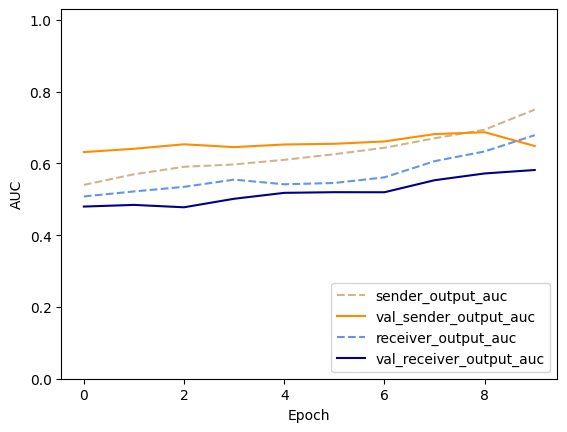

========== Test Evaluation ==========
78/78 - 3s - loss: 0.5571 - sender_output_loss: 0.3077 - receiver_output_loss: 0.2494 - sender_output_auc: 0.5861 - receiver_output_auc_1: 0.5830 - 3s/epoch - 38ms/step

========== Test Metrics ==========
78/78 [==============================] - 4s 35ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.929     0.945     0.937      2268
       False      0.253     0.203     0.225       207

    accuracy                          0.883      2475
   macro avg      0.591     0.574     0.581      2475
weighted avg      0.872     0.883     0.877      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.940     0.929     0.935      2310
       False      0.147     0.170     0.157       165

    accuracy                          0.879      2475
   macro avg      0.543     0.550     0.546      2475
weighted avg      0.887     0

In [132]:
context_bilstm_cnn_model = create_context_bilstm_cnn_model()
context_bilstm_cnn_model.summary()

context_bilstm_cnn_history = context_bilstm_cnn_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_cnn_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_cnn_history)


In [133]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

In [134]:
from tokenizers import ByteLevelBPETokenizer

# Initialize a tokenizer
bpe_tokenizer = ByteLevelBPETokenizer()

# Get a list of all messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Train the tokenizer
bpe_tokenizer.train_from_iterator(all_messages, vocab_size=VOCAB_SIZE)

def bpe_tokenize_and_pad(tokenizer, col, max_length):
    input_ids = []

    for sent in col:
        encoded = tokenizer.encode(sent)
        # Padding and truncating
        padding_length = max_length - len(encoded.ids)
        ids = encoded.ids + [0] * padding_length if padding_length > 0 else encoded.ids[:max_length]
        input_ids.append(ids)

    return tf.convert_to_tensor(input_ids)

train_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, train_df['messages'], MAX_SEQUENCE_LEN)
test_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, test_df['messages'], MAX_SEQUENCE_LEN)
validation_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, validation_df['messages'], MAX_SEQUENCE_LEN)

train_prev_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, train_df['previous_message'], MAX_SEQUENCE_LEN)
test_prev_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, test_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, validation_df['previous_message'], MAX_SEQUENCE_LEN)


In [135]:
def create_context_bilstm_model_bpe(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.1,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input_bpe = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input_bpe = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Embedding and Bi-LSTM layers
    current_message_bilstm_bpe = pipe(
        current_message_input_bpe,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bilstm_bpe = pipe(
        previous_message_input_bpe,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-LSTM outputs
    context_bilstm_output = pipe(
        [
            current_message_bilstm_bpe,
            previous_message_bilstm_bpe
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    # Model
    context_bilstm_model_bpe = keras.Model(
        inputs=[current_message_input_bpe, previous_message_input_bpe],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_model_bpe.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model_bpe


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_24 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                      

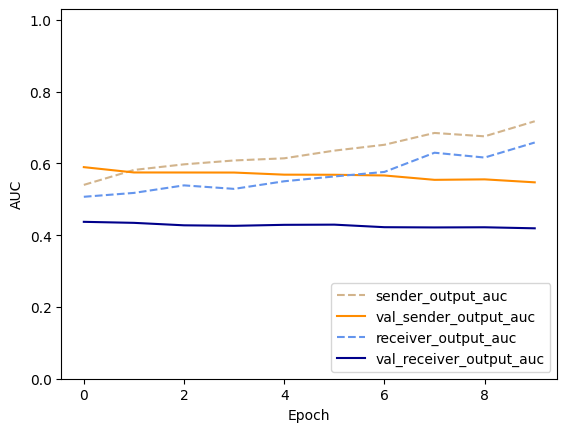

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5613 - sender_output_loss: 0.3172 - receiver_output_loss: 0.2441 - sender_output_auc: 0.5982 - receiver_output_auc_1: 0.5971 - 5s/epoch - 67ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 65ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.919     0.951     0.935      2268
       False      0.140     0.087     0.107       207

    accuracy                          0.879      2475
   macro avg      0.529     0.519     0.521      2475
weighted avg      0.854     0.879     0.866      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.943     0.804     0.868      2310
       False      0.103     0.315     0.155       165

    accuracy                          0.771      2475
   macro avg      0.523     0.560     0.511      2475
weighted avg      0.887     0

In [136]:
context_bilstm_model_bpe = create_context_bilstm_model_bpe()
context_bilstm_model_bpe.summary()

context_bilstm_history_bpe = context_bilstm_model_bpe.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded_bpe, validation_prev_encoded_padded_bpe], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_model_bpe, [test_encoded_padded_bpe, test_prev_encoded_padded_bpe], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_history_bpe)


# Bi-LSTM with SpaCy linguistic features

In [137]:
# Load SpaCy model
import spacy
nlp = spacy.load('en_core_web_sm')

def extract_features(text):
    doc = nlp(text)
    features = {
        "pos_tags": [token.pos_ for token in doc],
        "ner_tags": [ent.label_ for ent in doc.ents],
        # Add more features as needed
    }
    return features


In [138]:
import spacy
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

# Load SpaCy model for English
nlp = spacy.load("en_core_web_sm")

def extract_pos_tags(texts, max_len):
    pos_tags = []
    for doc in nlp.pipe(texts):
        tags = [token.pos_ for token in doc]
        pos_tags.append(tags)
    pos_tag_index = {tag: i + 1 for i, tag in enumerate(set(tag for tags in pos_tags for tag in tags))}
    encoded_tags = [[pos_tag_index[tag] for tag in tags] for tags in pos_tags]
    padded_tags = pad_sequences(encoded_tags, maxlen=max_len, padding='post')
    return np.array(padded_tags)

# Extract POS tags from datasets
train_pos_tags = extract_pos_tags(train_df['messages'], MAX_SEQUENCE_LEN)
test_pos_tags = extract_pos_tags(test_df['messages'], MAX_SEQUENCE_LEN)
validation_pos_tags = extract_pos_tags(validation_df['messages'], MAX_SEQUENCE_LEN)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_26 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inp

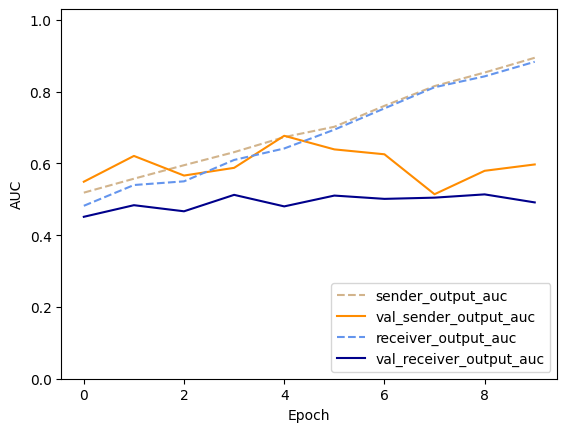

========== Test Evaluation ==========
78/78 - 5s - loss: 0.6805 - sender_output_loss: 0.3700 - receiver_output_loss: 0.3104 - sender_output_auc: 0.5737 - receiver_output_auc_1: 0.5496 - 5s/epoch - 68ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 65ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.924     0.963     0.943      2268
       False      0.243     0.130     0.170       207

    accuracy                          0.893      2475
   macro avg      0.584     0.547     0.556      2475
weighted avg      0.867     0.893     0.878      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.938     0.954     0.946      2310
       False      0.157     0.121     0.137       165

    accuracy                          0.898      2475
   macro avg      0.548     0.537     0.541      2475
weighted avg      0.886     0

In [139]:


def create_context_bilstm_model_spacy(
        sequence_length,
        embedding_output,
        vocab_size,
        lstm_size,
        dropout,
        hidden_size,
        learning_rate,
        linguistic_feature_size):

    current_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    current_linguistic_input = layers.Input(shape=(linguistic_feature_size,), name='current_linguistic_input')
    previous_linguistic_input = layers.Input(shape=(linguistic_feature_size,), name='previous_linguistic_input')

    embedding = layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)
    current_embed = embedding(current_message_input)
    previous_embed = embedding(previous_message_input)

    def bi_lstm_layer(input_layer):
        return layers.Bidirectional(layers.LSTM(lstm_size))(input_layer)

    current_message_bilstm = bi_lstm_layer(current_embed)
    previous_message_bilstm = bi_lstm_layer(previous_embed)

    current_combined = layers.Concatenate()([current_message_bilstm, current_linguistic_input])
    previous_combined = layers.Concatenate()([previous_message_bilstm, previous_linguistic_input])

    context_bilstm_output = layers.Concatenate()([current_combined, previous_combined])
    context_bilstm_output = layers.Dense(hidden_size)(context_bilstm_output)

    sender_output = layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_output)
    receiver_output = layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_output)

    context_bilstm_model_spacy = models.Model(
        inputs=[current_message_input, previous_message_input, current_linguistic_input, previous_linguistic_input],
        outputs=[sender_output, receiver_output]
    )

    context_bilstm_model_spacy.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model_spacy

# Extract POS tags from datasets
train_pos_tags = extract_pos_tags(train_df['messages'], MAX_SEQUENCE_LEN)
test_pos_tags = extract_pos_tags(test_df['messages'], MAX_SEQUENCE_LEN)
validation_pos_tags = extract_pos_tags(validation_df['messages'], MAX_SEQUENCE_LEN)

# Create and compile the model
context_bilstm_model_spacy = create_context_bilstm_model_spacy(
    sequence_length=294,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.25,
    hidden_size=1000,
    learning_rate=3e-5,
    linguistic_feature_size=train_pos_tags.shape[1]
)

# Model summary
context_bilstm_model_spacy.summary()

# Train the model
context_bilstm_history_spacy = context_bilstm_model_spacy.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_pos_tags, train_pos_tags],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_pos_tags, validation_pos_tags],
                     [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

# Assuming EvaluateModel is a custom function that you have defined for model evaluation
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_model_spacy,
    [test_encoded_padded, test_prev_encoded_padded, test_pos_tags, test_pos_tags],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_history_spacy
)


In [140]:
train_df

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
7,"Sorry Italy I've been away doing, um, German t...",True,True,germany,italy,117,7,Spring,1901,3,0.0,1,0,Any thoughts?,straightforward,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,Is there any way of me actually ending this co...,True,True,france,england,380,11,Fall,1902,4,-1.0,10,187,I guess we will see what happens,straightforward,0,0
13128,Can we agree on peace? What are your demands?,True,True,france,england,433,12,Fall,1902,4,-1.0,10,187,Is there any way of me actually ending this co...,straightforward,0,0
13129,"Neutrality in exchange for current holdings, S...",True,False,england,france,434,13,Fall,1902,5,1.0,10,187,Can we agree on peace? What are your demands?,cassandra,0,1
13130,"Thats a bit too much, can I keep Spain and i h...",True,True,france,england,437,14,Fall,1902,4,-1.0,10,187,"Neutrality in exchange for current holdings, S...",straightforward,0,0


# Bi-Directional Context LSTM with Power

In [48]:
def create_context_bilstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.15,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 3e-5,
    ):

    # Input layers
    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    # Embedding layer
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Apply embedding and Bi-LSTM to current and previous messages
    current_message_embedded = embedding_layer(current_message_input)
    previous_message_embedded = embedding_layer(previous_message_input)

    current_message_bilstm = pipe(
        current_message_embedded,
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    previous_message_bilstm = pipe(
        previous_message_embedded,
        keras.layers.Bidirectional(keras.layers.LSTM(lstm_size)),
        keras.layers.Dropout(dropout)
    )

    # Concatenate Bi-LSTM outputs with power differential input
    context_bilstm_power_output = keras.layers.Concatenate()(
        [current_message_bilstm, previous_message_bilstm, power_diff_input]
    )

    # Dense layer and outputs
    context_bilstm_power_output = keras.layers.Dense(hidden_size)(context_bilstm_power_output)
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_power_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_power_output)

    # Model creation
    context_bilstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile the model
    context_bilstm_power_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_power_model

In [142]:
train_encoded_padded

array([[   0,    0,    0, ..., 1469,    6, 1229],
       [   0,    0,    0, ...,  391,    5,  832],
       [   0,    0,    0, ...,    0,    0, 1108],
       ...,
       [   0,    0,    0, ...,   34, 2877,  118],
       [   0,    0,    0, ...,   99,  450,  252],
       [   0,    0,    0, ...,    0,   94, 2850]], dtype=int32)

In [49]:
# Reshape 'game_score_delta' to have an additional dimension
train_power_diff = train_df['game_score_delta']
test_power_diff = test_df['game_score_delta']
validation_power_diff = validation_df['game_score_delta']

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_7 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inpu

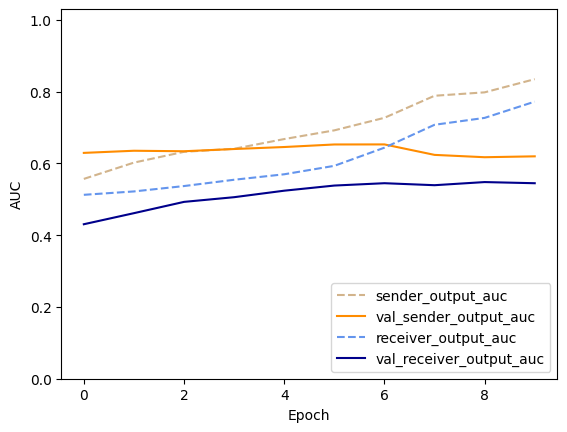

========== Test Evaluation ==========
78/78 - 6s - loss: 0.5423 - sender_output_loss: 0.2969 - receiver_output_loss: 0.2455 - sender_output_auc: 0.6427 - receiver_output_auc_1: 0.6157 - 6s/epoch - 82ms/step

========== Test Metrics ==========
78/78 [==============================] - 7s 79ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.929     0.934     0.932      2268
       False      0.232     0.217     0.224       207

    accuracy                          0.874      2475
   macro avg      0.580     0.576     0.578      2475
weighted avg      0.871     0.874     0.872      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.941     0.921     0.931      2310
       False      0.146     0.188     0.164       165

    accuracy                          0.872      2475
   macro avg      0.543     0.555     0.547      2475
weighted avg      0.888     0

In [50]:


context_bilstm_power_model = create_context_bilstm_power_model()
context_bilstm_power_model.summary()

# Training the model
context_bilstm_power_history = context_bilstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_power_diff],  # Including reshaped power differential input
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded, validation_prev_encoded_padded, validation_power_diff],  # Including reshaped power differential input
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=10
)

sender_threshold, receiver_threshold = EvaluateModel(context_bilstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_power_diff], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_bilstm_power_history)

# Unigram Tokenizer

In [145]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [146]:
# Assuming all_messages is a list of text messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Write messages to a text file
with open('all_messages.txt', 'w', encoding='utf-8') as file:
    for message in all_messages:
        file.write(message + '\n')

In [147]:
train_df

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
7,"Sorry Italy I've been away doing, um, German t...",True,True,germany,italy,117,7,Spring,1901,3,0.0,1,0,Any thoughts?,straightforward,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,Is there any way of me actually ending this co...,True,True,france,england,380,11,Fall,1902,4,-1.0,10,187,I guess we will see what happens,straightforward,0,0
13128,Can we agree on peace? What are your demands?,True,True,france,england,433,12,Fall,1902,4,-1.0,10,187,Is there any way of me actually ending this co...,straightforward,0,0
13129,"Neutrality in exchange for current holdings, S...",True,False,england,france,434,13,Fall,1902,5,1.0,10,187,Can we agree on peace? What are your demands?,cassandra,0,1
13130,"Thats a bit too much, can I keep Spain and i h...",True,True,france,england,437,14,Fall,1902,4,-1.0,10,187,"Neutrality in exchange for current holdings, S...",straightforward,0,0


In [148]:
# Assuming all_messages is a list of text messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Write messages to a text file
with open('all_messages.txt', 'w', encoding='utf-8') as file:
    for message in all_messages:
        file.write(message + '\n')

import sentencepiece as spm

# Train the unigram tokenizer
sp = spm.SentencePieceProcessor()
spm.SentencePieceTrainer.train(input='all_messages.txt', model_prefix='unigram', vocab_size=VOCAB_SIZE, model_type='unigram')

# Load the trained model
sp.load('unigram.model')

def unigram_tokenize_and_pad(sp, col, max_length):
    input_ids = []

    for sent in col:
        encoded = sp.encode_as_ids(sent)
        # Padding and truncating
        padding_length = max_length - len(encoded)
        ids = encoded + [0] * padding_length if padding_length > 0 else encoded[:max_length]
        input_ids.append(ids)

    return tf.convert_to_tensor(input_ids)

# Preprocess your data
train_encoded_padded_unigram = unigram_tokenize_and_pad(sp, train_df['messages'], MAX_SEQUENCE_LEN)
test_encoded_padded_unigram = unigram_tokenize_and_pad(sp, test_df['messages'], MAX_SEQUENCE_LEN)
validation_encoded_padded_unigram = unigram_tokenize_and_pad(sp, validation_df['messages'], MAX_SEQUENCE_LEN)

# Tokenize and pad previous messages using the Unigram tokenizer
train_prev_encoded_padded_unigram = unigram_tokenize_and_pad(sp, train_df['previous_message'], MAX_SEQUENCE_LEN)
test_prev_encoded_padded_unigram = unigram_tokenize_and_pad(sp, test_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_encoded_padded_unigram = unigram_tokenize_and_pad(sp, validation_df['previous_message'], MAX_SEQUENCE_LEN)



In [149]:
from tensorflow import keras
import tensorflow as tf

def create_context_bilstm_model_unigram_with_power(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.1,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input_unigram = keras.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input_unigram = keras.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.Input(shape=(1,), name='power_differential')

    # Embedding layer
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Bi-LSTM layers applied to the current and previous messages
    current_message_embedded = embedding_layer(current_message_input_unigram)
    current_message_bilstm_unigram = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(current_message_embedded)
    current_message_bilstm_unigram = keras.layers.Dropout(dropout)(current_message_bilstm_unigram)

    previous_message_embedded = embedding_layer(previous_message_input_unigram)
    previous_message_bilstm_unigram = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(previous_message_embedded)
    previous_message_bilstm_unigram = keras.layers.Dropout(dropout)(previous_message_bilstm_unigram)

    # Concatenate Bi-LSTM outputs with power differential input
    context_bilstm_power_output = keras.layers.Concatenate()([
        current_message_bilstm_unigram,
        previous_message_bilstm_unigram,
        power_diff_input
    ])
    context_bilstm_power_output = keras.layers.Dense(hidden_size, activation='relu')(context_bilstm_power_output)

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_power_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_power_output)

    # Model
    context_bilstm_model_unigram_with_power = keras.Model(
        inputs=[current_message_input_unigram, previous_message_input_unigram, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_model_unigram_with_power.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model_unigram_with_power


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_28 (Embedding)    (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inp

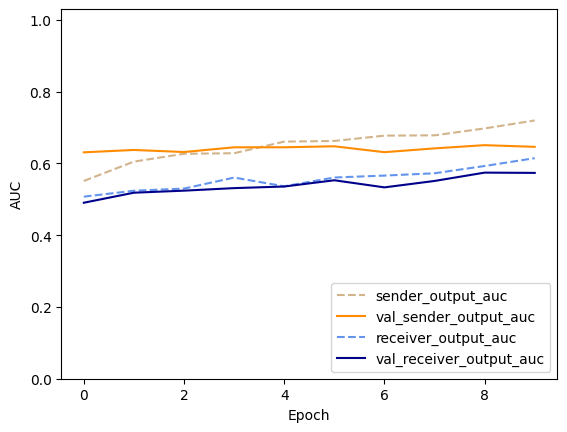

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5257 - sender_output_loss: 0.2833 - receiver_output_loss: 0.2424 - sender_output_auc: 0.6692 - receiver_output_auc_1: 0.6114 - 5s/epoch - 68ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 65ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.932     0.921     0.926      2268
       False      0.231     0.261     0.245       207

    accuracy                          0.865      2475
   macro avg      0.581     0.591     0.586      2475
weighted avg      0.873     0.865     0.869      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.940     0.891     0.915      2310
       False      0.116     0.200     0.147       165

    accuracy                          0.845      2475
   macro avg      0.528     0.545     0.531      2475
weighted avg      0.885     0

In [150]:
# Create the model
context_bilstm_power_unigram_model = create_context_bilstm_model_unigram_with_power(
    sequence_length=MAX_SEQUENCE_LEN,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.1,
    hidden_size=HIDDEN_LAYER_SIZE,
    learning_rate=2e-5
)
context_bilstm_power_unigram_model.summary()

# Tokenize and pad data
# Assuming you have tokenized and padded your training, validation, and test data
# with the unigram tokenizer and prepared your power differential inputs as `train_power_diff`, `validation_power_diff`, `test_power_diff`

# Training the model
context_bilstm_power_unigram_history = context_bilstm_power_unigram_model.fit(
    [train_encoded_padded_unigram, train_prev_encoded_padded_unigram, train_power_diff],  # Including reshaped power differential input
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded_unigram, validation_prev_encoded_padded_unigram, validation_power_diff],  # Including reshaped power differential input
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=10
)

# EvaluateModel function should be defined to evaluate your model
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_power_unigram_model,
    [test_encoded_padded_unigram, test_prev_encoded_padded_unigram, test_power_diff],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_power_unigram_history
)


In [151]:
# def create_combined_model(sequence_length, embedding_output, vocab_size, lstm_size, dropout, hidden_size, learning_rate, pos_tags_dim):
#     # Keras Message Inputs
#     current_message_input_keras = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input_keras')
#     previous_message_input_keras = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input_keras')

#     # Unigram and BPE Message Inputs
#     current_message_input_unigram = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input_unigram')
#     previous_message_input_unigram = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input_unigram')
#     current_message_input_bpe = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input_bpe')
#     previous_message_input_bpe = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input_bpe')

#     # POS tags input
#     current_pos_input = layers.Input(shape=(pos_tags_dim,), name='current_pos_input')
#     previous_pos_input = layers.Input(shape=(pos_tags_dim,), name='previous_pos_input')

#     # Power differential input
#     power_diff_input = layers.Input(shape=(1,), name='power_differential')

#     # Embedding layer
#     embedding = layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

#     # Bi-LSTM layers for each text input type
#     def process_text_input(input_layer):
#         embedded = embedding(input_layer)
#         return layers.Bidirectional(layers.LSTM(lstm_size))(embedded)

#     current_keras_bilstm = process_text_input(current_message_input_keras)
#     previous_keras_bilstm = process_text_input(previous_message_input_keras)
#     current_unigram_bilstm = process_text_input(current_message_input_unigram)
#     previous_unigram_bilstm = process_text_input(previous_message_input_unigram)
#     #current_bpe_bilstm = process_text_input(current_message_input_bpe)
#     #previous_bpe_bilstm = process_text_input(previous_message_input_bpe)

#     # Dense layer for SpaCy features
#     spacy_dense = layers.Dense(hidden_size, activation='relu')(current_pos_input)  # Assuming similar processing for current and previous

#     # Concatenate all inputs
#     concatenated = layers.Concatenate()([
#         current_keras_bilstm, previous_keras_bilstm, current_unigram_bilstm, previous_unigram_bilstm,
#         current_bpe_bilstm, previous_bpe_bilstm, spacy_dense, power_diff_input
#     ])

#     # Dense layers
#     dense_output = layers.Dense(hidden_size, activation='relu')(concatenated)
#     dense_output = layers.Dropout(dropout)(dense_output)

#     # Output layers
#     sender_output = layers.Dense(1, activation='sigmoid', name='sender_output')(dense_output)
#     receiver_output = layers.Dense(1, activation='sigmoid', name='receiver_output')(dense_output)

#     # Build the model
#     model = models.Model(
#         inputs=[
#             current_message_input_keras, previous_message_input_keras, current_message_input_unigram, previous_message_input_unigram,
#             current_message_input_bpe, previous_message_input_bpe, current_pos_input, previous_pos_input, power_diff_input
#         ],
#         outputs=[sender_output, receiver_output]
#     )

#     # Compile the model
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         metrics=['AUC']
#     )

#     return model

# # Create and compile the model
# combined_model = create_combined_model(
#     sequence_length=MAX_SEQUENCE_LEN,
#     embedding_output=EMBEDDING_OUTPUT_SIZE,
#     vocab_size=VOCAB_SIZE,
#     lstm_size=600,
#     dropout=0.2,
#     hidden_size=HIDDEN_LAYER_SIZE,
#     learning_rate=3e-5,
#     pos_tags_dim=train_pos_tags.shape[1]
# )

# # Train the model
# combined_model_history = combined_model.fit(
#     [train_encoded_padded, train_prev_encoded_padded, train_encoded_padded_unigram, train_prev_encoded_padded_unigram,
#      train_encoded_padded_bpe, train_prev_encoded_padded_bpe, train_pos_tags, train_pos_tags, train_power_diff],
#     [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
#     validation_data=(
#         [validation_encoded_padded, validation_prev_encoded_padded, validation_encoded_padded_unigram, validation_prev_encoded_padded_unigram,
#          validation_encoded_padded_bpe, validation_prev_encoded_padded_bpe, validation_pos_tags, validation_pos_tags, validation_power_diff],
#         [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
#     ),
#     epochs=20,
#     batch_size=256
# )

# # Evaluate the model
# sender_threshold, receiver_threshold = EvaluateModel(
#     combined_model,
#     [test_encoded_padded, test_prev_encoded_padded, test_encoded_padded_unigram, test_prev_encoded_padded_unigram,
#      test_encoded_padded_bpe, test_prev_encoded_padded_bpe, test_pos_tags, test_pos_tags, test_power_diff],
#     [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
#     combined_model_history
# )


Epoch 1/20


InternalError: ignored

In [ ]:
def create_context_bilstm_model_all_features(
        sequence_length: int,
        embedding_output: int,
        vocab_size: int,
        lstm_size: int,
        dropout: float,
        hidden_size: int,
        learning_rate: float,
        spacy_feature_size: int
    ):

    # Existing Unigram Message Inputs
    current_message_input = keras.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    # Additional Inputs
    power_diff_input = keras.Input(shape=(1,), name='power_differential')
    spacy_input = keras.Input(shape=(spacy_feature_size,), name='spacy_input')

    # Embedding and LSTM layers for Unigram Inputs
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)
    current_embedded = embedding_layer(current_message_input)
    previous_embedded = embedding_layer(previous_message_input)
    current_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(current_embedded)
    previous_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(previous_embedded)

    # Process the SpaCy Input
    spacy_dense = keras.layers.Dense(hidden_size, activation='relu')(spacy_input)

    # Concatenate all inputs
    concatenated = keras.layers.Concatenate()([
        current_bilstm, previous_bilstm, power_diff_input, spacy_dense
    ])

    # Dense layers
    dense_output = keras.layers.Dense(hidden_size, activation='relu')(concatenated)

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(dense_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(dense_output)

    # Build the Model
    model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input, spacy_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile the Model
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model


In [ ]:
# Create the model
context_bilstm_all_features_model = create_context_bilstm_model_all_features(
    sequence_length=MAX_SEQUENCE_LEN,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.1,
    hidden_size=HIDDEN_LAYER_SIZE,
    learning_rate=2e-5,
    spacy_feature_size=SPACY_FEATURE_DIM  # Make sure to set this appropriately
)
context_bilstm_all_features_model.summary()

# Training the model
context_bilstm_all_features_history = context_bilstm_all_features_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_power_diff, train_spacy_features],  # Including SpaCy features
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded, validation_prev_encoded_padded, validation_power_diff, validation_spacy_features],  # Including SpaCy features
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=10
)

# EvaluateModel function should be defined to evaluate your model
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_all_features_model,
    [test_encoded_padded, test_prev_encoded_padded, test_power_diff, test_spacy_features],  # Including SpaCy features
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_all_features_history
)
